# Imports and constants

In [1]:
import os
import math
import time
import random
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm.notebook import tqdm

In [2]:
# custom imports
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..', 'utils')))

In [3]:
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta',
    'yellow', 'black', 'orange', 'purple', 'brown',
    'pink', 'grey', 'maroon', 'gold', 'chocolate',
    'aqua', 'darkviolet', 'crimson', 'navy', 'darkgreen',
    'peru', 'tan', 'seagreen', 'darkslategrey', 'teal'
]

In [4]:
# constants
A = 3e-4

## Load dataset

In [5]:
# root_dir = os.path.join('..', '..', '..', 'data', 'pdg13', 'pdg13-n25-69GeV-0.5eta')
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13', 'pdg13-n25-0.5to10GeV-0.5eta')

hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
initial_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_initial.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])

dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
       for file in hit_files]
initial_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
               for file in initial_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

In [6]:
random.seed(2021)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
initial_df = initial_dfs[random_event]
final_df = final_dfs[random_event]
df['weight'] = 1.0
df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
df['phi'] = np.arctan2(df['ty'], df['tx'])
df['track'] = df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
df.head()

Event chosen: event000000051-hits.csv


,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index,weight,r,phi,track
0,4503599996469248,936748859932016652,31.950581,1.960413,10.167611,0.112050,5.853292,0.368759,1.862878,6.154550,0,0,0,0,0,1.0,32.010667,0.061281,"(32.01066730968359, 0.061280853128180386)"
1,4503600046800896,936748859932016652,31.212055,8.084858,8.601591,0.111488,1.746427,0.462362,0.481962,1.872762,0,0,0,0,0,1.0,32.242167,0.253459,"(32.24216676524436, 0.25345924255447094)"
2,4503600046800896,936748859932016666,32.001701,8.294030,8.819519,0.114312,1.746301,0.462835,0.481962,1.872762,0,0,0,0,1,1.0,33.059036,0.253595,"(33.059035516593546, 0.25359482670913647)"
3,4503599660924928,936748859932016679,-29.345648,-17.591038,-10.955899,0.119842,-7.877036,-4.733791,-2.942781,9.650265,0,0,0,0,1,1.0,34.214203,-2.601583,"(34.21420254342739, -2.601582947009528)"
4,4503599728033792,936748859932016679,-27.635937,-18.932758,1.574936,0.111876,-6.144863,-4.221881,0.350511,7.464425,0,0,0,0,1,1.0,33.499169,-2.540952,"(33.499169155855576, -2.540952158240271)"


## Plot the Original and Hough spaces

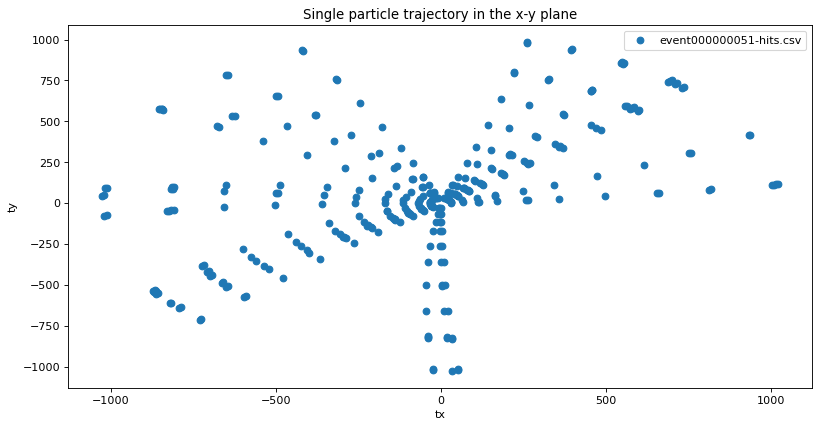

In [7]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(x=df['tx'], y=df['ty'], label=hit_files[random_event])

plt.xlabel('tx')
plt.ylabel('ty')
plt.legend(loc='best')
plt.title('Single particle trajectory in the x-y plane')
plt.show()

Let's plot the tracks in the Hough Space.

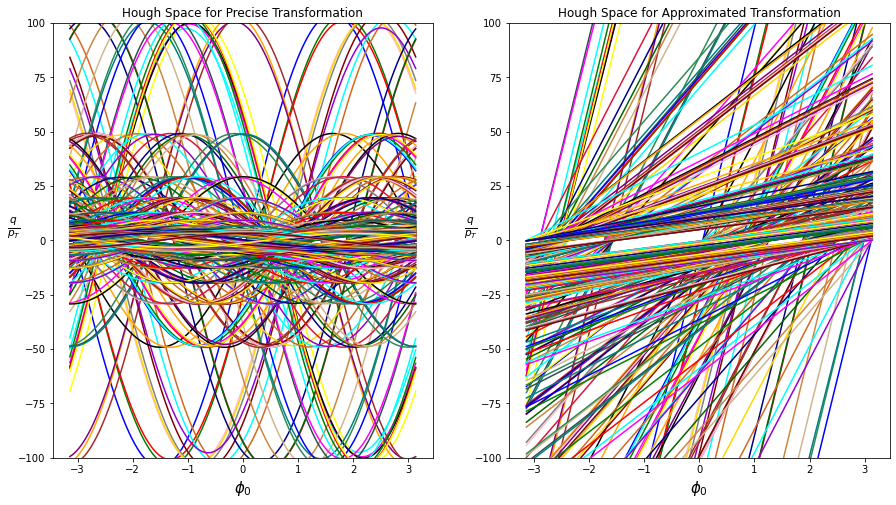

In [8]:
from notebook3_utils import plot_tracks_in_hough_space

tracks = list(df['track'])
phi_range = (-np.pi, np.pi)
ylims = (-100, 100)
plot_tracks_in_hough_space(tracks, phi_range, ylims, A, colors)

## Run the Hough Transform

Let's define here the hyperprameters.

In [9]:
all_tracks = list(df['track'])

common_bin_size = (0.01, 0.1)
common_nhits = 10

precise_hyperparams = {
    'bin-size': common_bin_size,
    'phi-range': (0, np.pi),
    'qpt-range': (-10000, 10000),
    'minimum-number-of-hits': common_nhits,
    'A': A
}

approx_hyperparams = {
    'bin-size': common_bin_size,
    'phi-range': (-np.pi, np.pi),
    'qpt-range': (-10000, 10000),
    'minimum-number-of-hits': common_nhits,
    'A': A
}

Let's populate two accumulator arrays to see if we can spot any differences.

In [10]:
from notebook3_utils import populate_accumulators

precise_result, approx_result = populate_accumulators(all_tracks, precise_hyperparams, approx_hyperparams)

precise_accumulator, precise_est_tracks_to_hits = precise_result
approx_accumulator, approx_est_tracks_to_hits = approx_result

## Define the region to "zoom in".

In [11]:
from notebook3_utils import get_roi_accumulators

precise_lower_phi = 0.0; precise_upper_phi = np.pi; precise_roi_phis = (precise_lower_phi, precise_upper_phi)
approx_lower_phi = -np.pi; approx_upper_phi = np.pi; approx_roi_phis = (approx_lower_phi, approx_upper_phi)

precise_lower_qpt = -2; precise_upper_qpt = 2; precise_roi_qpts = (precise_lower_qpt, precise_upper_qpt)
approx_lower_qpt = -2; approx_upper_qpt = 2; approx_roi_qpts = (approx_lower_qpt, approx_upper_qpt)

accumulators = (precise_accumulator, approx_accumulator)
precise_rois = (precise_roi_phis, precise_roi_qpts)
approx_rois = (approx_roi_phis, approx_roi_qpts)

roi_accumulators = get_roi_accumulators(accumulators, precise_hyperparams, approx_hyperparams,
                                        precise_rois, approx_rois)
roi_precise_accumulator, roi_approx_accumulator = accumulators

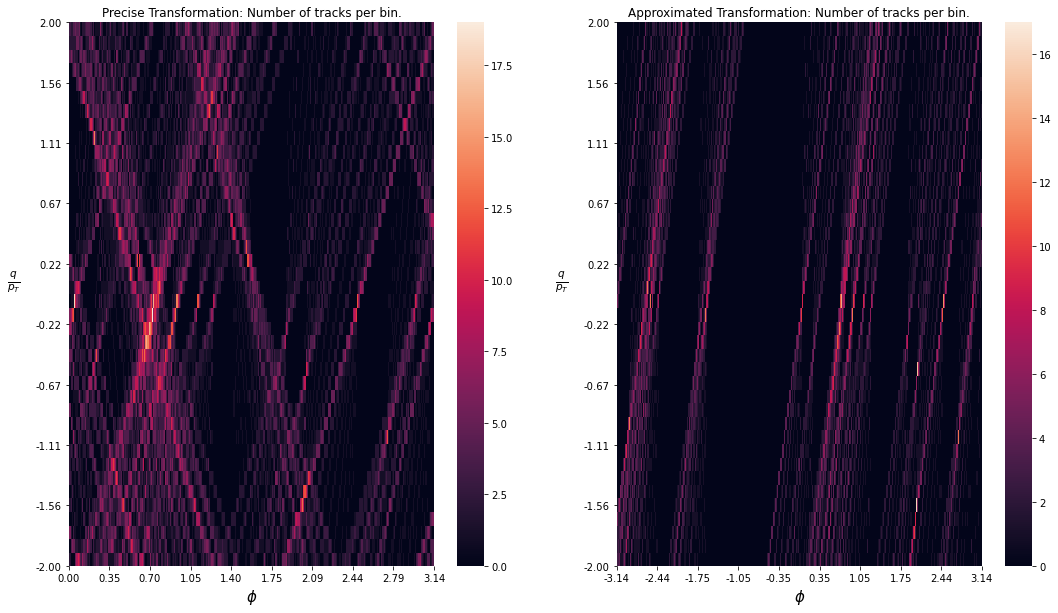

In [12]:
from notebook3_utils import plot_heatmaps

plot_heatmaps(roi_accumulators, precise_rois, approx_rois)

## Let's also compute the rates.

In [13]:
from metrics import efficiency_rate, fake_rate, duplicate_rate

precise_eff = efficiency_rate(precise_est_tracks_to_hits.values(), df)
precise_fake = fake_rate(precise_est_tracks_to_hits.values(), df)
precise_dup = duplicate_rate(precise_est_tracks_to_hits.values(), df)

approx_eff = efficiency_rate(approx_est_tracks_to_hits.values(), df)
approx_fake = fake_rate(approx_est_tracks_to_hits.values(), df)
approx_dup = duplicate_rate(approx_est_tracks_to_hits.values(), df)

print(f'Precise Transformation Efficiency Rate:\t\t {precise_eff}')
print(f'Precise Transformation Fake Rate:\t\t {precise_fake}')
print(f'Precise Transformation Duplicate Rate:\t\t {precise_dup}')
print()
print(f'Approximated Transformation Efficiency Rate:\t {approx_eff}')
print(f'Approximated Transformation Fake Ratea;\t\t {approx_fake}')
print(f'Approximated Transformation Duplicate Rate:\t {approx_dup}')

Precise Transformation Efficiency Rate:		 0.8
Precise Transformation Fake Rate:		 0.51440329218107
Precise Transformation Duplicate Rate:		 0.9094650205761317

Approximated Transformation Efficiency Rate:	 0.76
Approximated Transformation Fake Ratea;		 0.05555555555555555
Approximated Transformation Duplicate Rate:	 0.4722222222222222


# Now let's calculate the efficiency for different $p_T$ and $\eta$ values

First we need to define a custom efficiency function that will return the reconstructed particles along with the actual efficiency rate.

In [14]:
from metrics import get_track_to_truth_row_mapping, matching_probability

def custom_efficiency_rate(hits_per_estimated_track, truth_df, threshold=0.5):
    """ Custom efficiency rate function. The difference is that it also returns the reconstructed particles. """
    num_true_particles = len(set(truth_df['particle_id']))
    track_to_truth_df_row = get_track_to_truth_row_mapping(truth_df)
    found_particles = set()
    for hits in hits_per_estimated_track:
        pid, prob = matching_probability(hits, track_to_truth_df_row, truth_df)
        if prob >= threshold:
            found_particles.add(pid)
        if len(found_particles) == num_true_particles:
            break

    return found_particles, len(found_particles) / len(set(truth_df['particle_id']))

Let's now find the min axd max values for $p_T$ and $\eta$.

In [15]:
pts = []
etas = []

for df, initial_df in zip(dfs, initial_dfs):
    
    df['weight'] = 1.0
    df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
    df['phi'] = np.arctan2(df['ty'], df['tx'])
    df['track'] = df[['r', 'phi']].apply(lambda pair: (pair[0], pair[1]), 1)

    initial_df['pt'] = np.sqrt(initial_df['px'] ** 2 + initial_df['py'] ** 2)
    initial_df['|p|'] = np.sqrt(initial_df['px'] ** 2 + initial_df['py'] ** 2 + initial_df['pz'] ** 2)
    initial_df['theta'] = np.arccos(initial_df['pz'] / initial_df['|p|'])
    initial_df['eta'] = -np.log(np.tan(initial_df['theta'] / 2))
    
    for pt, eta in zip(initial_df['pt'], initial_df['eta']):
        pts.append(pt)
        etas.append(eta)

pts = list(set(pts))
etas = list(set(etas))

pt_min = min(pts)
pt_max = max(pts)
print(f'Min p_T = {pt_min},\tMax p_T = {pt_max}')

eta_min = min(etas)
eta_max = max(etas)
print(f'Min eta = {eta_min},\tMax eta = {eta_max}')

Min p_T = 0.47601325726136773,	Max p_T = 9.996729343147384
Min eta = -0.4999352632133841,	Max eta = 0.49970975214354924


Define the ranges of search and the dictionaries that will store the counts for each group.

In [16]:
from notebook3_utils import get_str

pt_number_of_bins = 10 if pt_max - pt_min >= 5 else 3
pt_bin_length = (pt_max - pt_min) / pt_number_of_bins

eta_number_of_bins = 10
eta_bin_length = (eta_max - eta_min) / eta_number_of_bins

pts_range = np.arange(pt_min, pt_max + 1e-8, pt_bin_length)
pt_keys = ['{} – {}'.format(get_str(pts_range[i]), get_str(pts_range[i+1]))
           for i in range(0, len(pts_range) - 1)]

etas_range = np.arange(eta_min, eta_max + 1e-8, eta_bin_length)
eta_keys = ['{} – {}'.format(get_str(etas_range[i]), get_str(etas_range[i+1]))
            for i in range(0, len(etas_range) - 1)]

In [17]:
# count particles found
pt_counts = {pt_range: 0 for pt_range in pt_keys}
eta_counts = {eta_range: 0 for eta_range in eta_keys}

precise_pt_counts = {pt_range: 0 for pt_range in pt_keys}
precise_eta_counts = {eta_range: 0 for eta_range in eta_keys}

approx_pt_counts = {pt_range: 0 for pt_range in pt_keys}
approx_eta_counts = {eta_range: 0 for eta_range in eta_keys}

Let's define the hyperparameters.

In [18]:
common_bin_size = (0.005, 0.1)
common_nhits = 10

precise_hyperparams = {
    'bin-size': common_bin_size,
    'phi-range': (0, np.pi),
    'qpt-range': (-10000, 10000),
    'minimum-number-of-hits': common_nhits,
    'A': A
}

approx_hyperparams = {
    'bin-size': common_bin_size,
    'phi-range': (-np.pi, np.pi),
    'qpt-range': (-10000, 10000),
    'minimum-number-of-hits': common_nhits,
    'A': A
}

Apply Hough transformation for every event (essentially the whole dataset) and keep track of the results.

In [19]:
desc = 'Applying Hough Transform to whole Dataset'
for df, initial_df in tqdm(zip(dfs, initial_dfs), total=len(dfs), desc=desc):

    # let's compute the ground truth counts
    for pt, eta in zip(list(initial_df['pt']), list(initial_df['eta'])):

        pt_bin = int((pt - pt_min - 1e-12) / pt_bin_length)
        eta_bin = int((eta - eta_min - 1e-12) / eta_bin_length)

        pt_counts[pt_keys[pt_bin]] += 1
        eta_counts[eta_keys[eta_bin]] += 1

    # get all the tracks
    all_tracks = list(df['track'])

    # get estimated tracks and reco particles for the precise and approximated transformations
    precise_result, approx_result = populate_accumulators(all_tracks, precise_hyperparams, approx_hyperparams)
    _, precise_est_tracks_to_hits = precise_result
    _, approx_est_tracks_to_hits = approx_result
    
    # get the IDs of the particles found
    precise_pids_found, _ = custom_efficiency_rate(precise_est_tracks_to_hits.values(), df)
    approx_pids_found, _ = custom_efficiency_rate(approx_est_tracks_to_hits.values(), df)
    
    # compute the precise counts
    for pid in precise_pids_found:
        pt = initial_df[initial_df['particle_id'] == pid]['pt'].item()
        eta = initial_df[initial_df['particle_id'] == pid]['eta'].item()

        pt_bin = int((pt - pt_min - 1e-12) / pt_bin_length)
        eta_bin = int((eta - eta_min - 1e-12) / eta_bin_length)

        precise_pt_counts[pt_keys[pt_bin]] += 1
        precise_eta_counts[eta_keys[eta_bin]] += 1

    # compute the approx counts
    for pid in approx_pids_found:
        pt = initial_df[initial_df['particle_id'] == pid]['pt'].item()
        eta = initial_df[initial_df['particle_id'] == pid]['eta'].item()

        pt_bin = int((pt - pt_min - 1e-12) / pt_bin_length)
        eta_bin = int((eta - eta_min - 1e-12) / eta_bin_length)

        approx_pt_counts[pt_keys[pt_bin]] += 1
        approx_eta_counts[eta_keys[eta_bin]] += 1

Applying Hough Transform to whole Dataset:   0%|          | 0/100 [00:00<?, ?it/s]

Now let's do the plots.

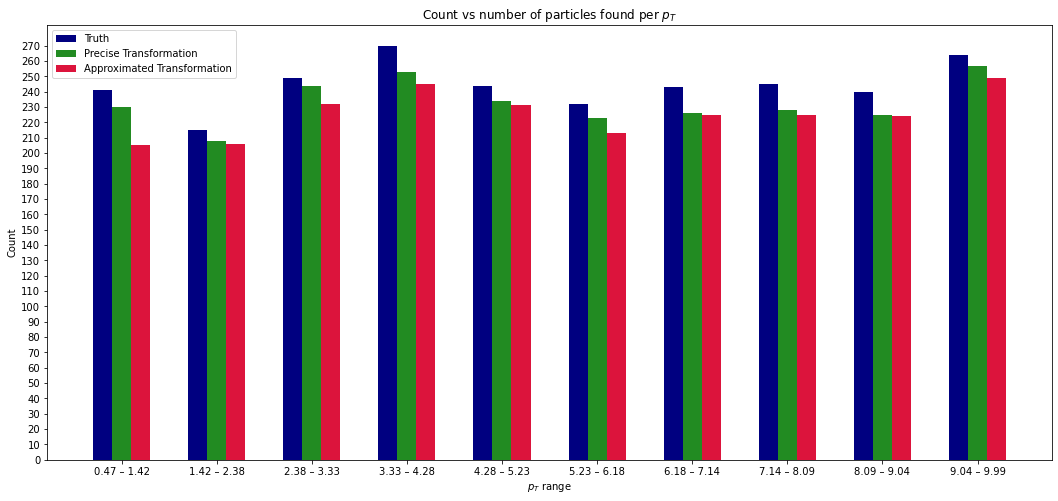

In [20]:
# plot count vs p_T
fig, ax = plt.subplots(figsize=(18, 8))

xticks_r = np.arange(0, len(pt_counts.keys()))
count_max = max(pt_counts.values())
bar_width = 0.2

ax.bar(xticks_r - bar_width, list(pt_counts.values()), color='navy', label='Truth',
       width=bar_width)
ax.bar(xticks_r, list(precise_pt_counts.values()), color='forestgreen',
       label='Precise Transformation', width=bar_width)
ax.bar(xticks_r + bar_width, list(approx_pt_counts.values()), color='crimson',
       label='Approximated Transformation', width=bar_width)

ax.set_xlabel('$p_T$ range')
ax.set_xticks(xticks_r)
ax.set_xticklabels(list(pt_counts.keys()))
ax.set_ylabel('Count')
freq = 10 if pt_max - pt_min >= 5 else 100
ax.set_yticks(np.arange(0, count_max + 1, freq))
ax.set_title('Count vs number of particles found per $p_T$')
ax.legend()

plt.show()

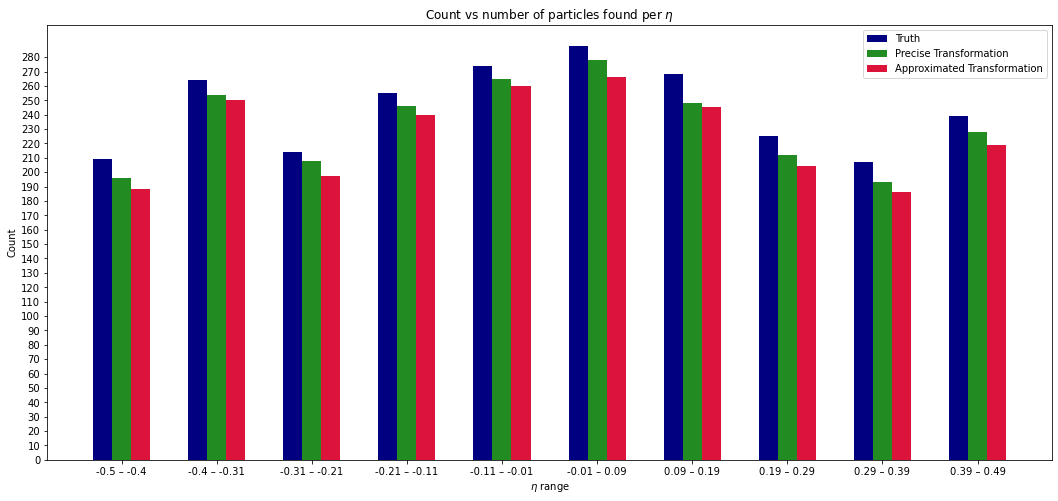

In [21]:
# plot count vs eta
fig, ax = plt.subplots(figsize=(18, 8))

xticks_r = np.arange(0, len(eta_counts.keys()))
count_max = max(eta_counts.values())
bar_width = 0.2

ax.bar(xticks_r - bar_width, list(eta_counts.values()), color='navy', label='Truth',
       width=bar_width)
ax.bar(xticks_r, list(precise_eta_counts.values()), color='forestgreen',
       label='Precise Transformation', width=bar_width)
ax.bar(xticks_r + bar_width, list(approx_eta_counts.values()), color='crimson',
       label='Approximated Transformation', width=bar_width)

ax.set_xlabel('$\eta$ range')
ax.set_xticks(xticks_r)
ax.set_xticklabels(list(eta_counts.keys()))
ax.set_ylabel('Count')
ax.set_yticks(np.arange(0, count_max + 1, 10))
ax.set_title('Count vs number of particles found per $\eta$')
ax.legend()

plt.show()

Let's plot now the efficiencies.

In [22]:
pt_precise_eff = {pt_range: precise_pt_counts[pt_range] / pt_counts[pt_range] for pt_range in pt_keys}
pt_approx_eff = {pt_range: approx_pt_counts[pt_range] / pt_counts[pt_range] for pt_range in pt_keys}

eta_precise_eff = {eta_range: precise_eta_counts[eta_range] / eta_counts[eta_range] for eta_range in eta_keys}
eta_approx_eff = {eta_range: approx_eta_counts[eta_range] / eta_counts[eta_range] for eta_range in eta_keys}

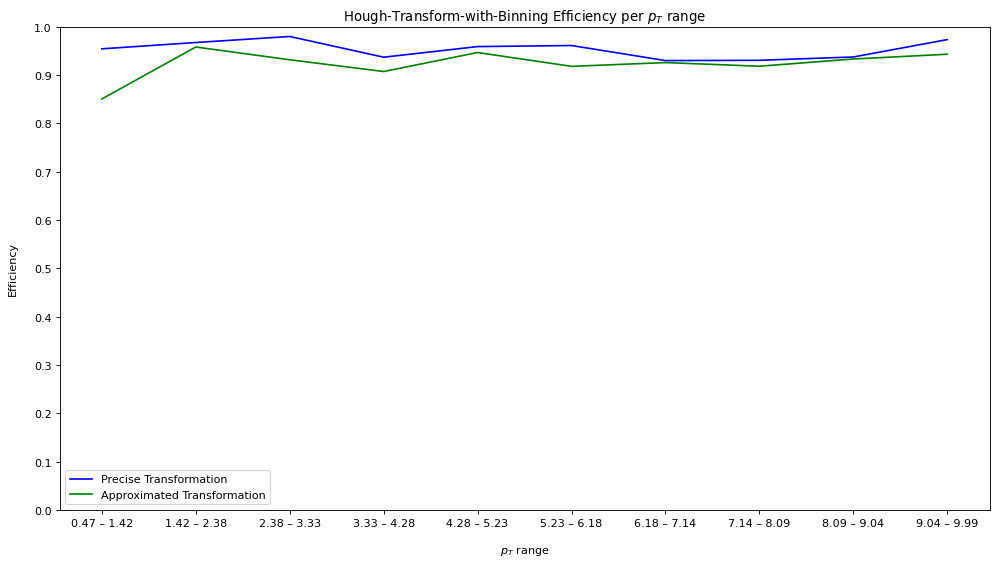

In [23]:
plt.figure(figsize=(15, 8), dpi=80)

plt.plot(list(pt_precise_eff.keys()), list(pt_precise_eff.values()), color='blue', label='Precise Transformation')
plt.plot(list(pt_approx_eff.keys()), list(pt_approx_eff.values()), color='green', label='Approximated Transformation')

plt.xlabel('\n$p_T$ range')
plt.ylabel('Efficiency\n')
plt.yticks(np.arange(0, 1.01, step=0.1))

plt.title('Hough-Transform-with-Binning Efficiency per $p_T$ range')
plt.legend()
plt.show()

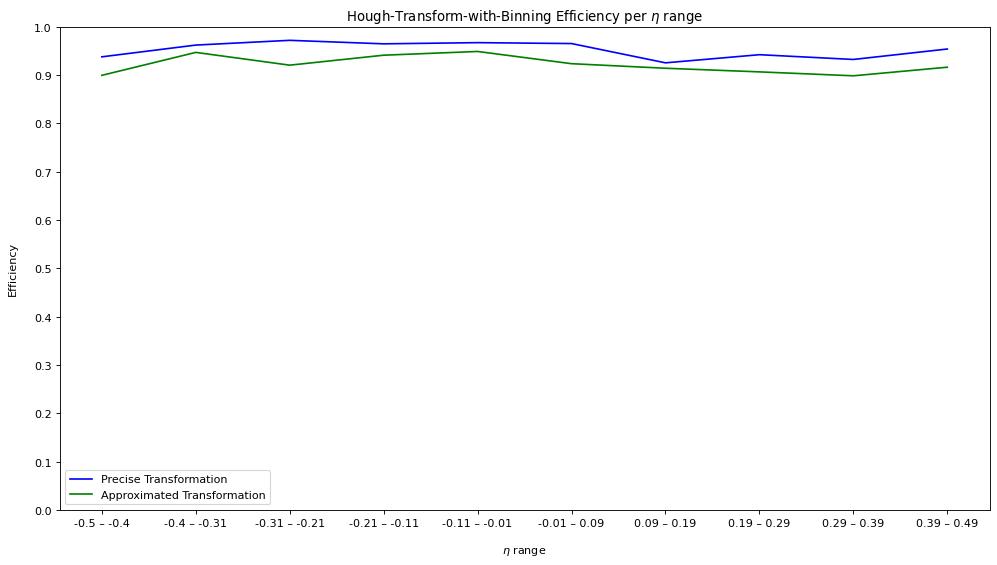

In [24]:
plt.figure(figsize=(15, 8), dpi=80)

plt.plot(list(eta_precise_eff.keys()), list(eta_precise_eff.values()), color='blue', label='Precise Transformation')
plt.plot(list(eta_approx_eff.keys()), list(eta_approx_eff.values()), color='green', label='Approximated Transformation')

plt.xlabel('\n$\eta$ range')
plt.ylabel('Efficiency\n')
plt.yticks(np.arange(0, 1.01, step=0.1))

plt.title('Hough-Transform-with-Binning Efficiency per $\eta$ range')
plt.legend(loc='best')
plt.show()